In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot as mat_mul
import pbdlib as pbd

### Load some data

In [2]:
data = scipy.io.loadmat('2Dletters/B.mat')

In [3]:
# Make a list with all demonstrations
demos = []
for data_demo in data.get('demos')[0]:
    demos.append(data_demo[0,0][0])
    
# Add a time input
for i in range(0,len(demos)):
    t = np.linspace(0,1,demos[i].shape[1])
    demos[i] = np.vstack((t,demos[i]))

In [4]:
N = len(demos)
N1 = demos[0].shape[0]
N2 = demos[0].shape[1]

tensor_data = [np.empty([N1,N2])]*N
for i in range(N):
    tensor_data[i] = demos[i][1:,:]

print("Number of demonstrations: ", len(tensor_data))
print("Shape of each tensor data: ", tensor_data[0].shape)

Number of demonstrations:  12
Shape of each tensor data:  (2, 200)


(-9.746535734560691,
 10.832151537529237,
 -10.252485741760404,
 9.116554388134835)

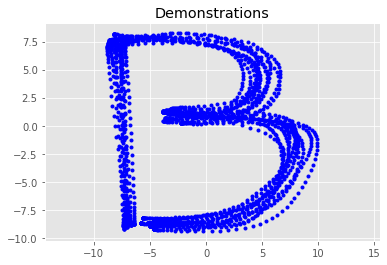

In [5]:
plt.figure
for i in range(0,len(demos)):
    plt.plot(demos[i][1,:],demos[i][2,:],'b.')
plt.title('Demonstrations')
plt.axis('equal')
#plt.axis('tight')

### Matrix-Normal Analysis

#### Fit the matrix normal to the data

In [6]:
from tensor_tools import array3
t_tools = array3()
Nb = 10 #Number of basis functions
M, Cov, A, Uw, Phi = t_tools.anormal2D(tensor_data,Nb,normalised=False)
Cov[0] = Cov[0]/1000000
Cov[1] = 1000000*Cov[1]

N, N1, N2:  12 2 200
Error EM:  229.76331087765982
0.40689323065572025 0.0
Error EM:  0.00132418678522981
0.4068959190540534 0.0
Error EM:  2.486796047343218e-08
0.40689591910673145 0.0
Error EM:  6.112569078369082e-10
0.4068959191074375 0.0
MLE has converged in  3  steps


In [7]:
print(Cov[0])
print(Cov[1])

[[1.00000000e-06 5.13521496e-08]
 [5.13521496e-08 4.09532962e-07]]
[[310132.94347248 287765.11281269 261777.94229762 ...  30759.79356393
   29310.84718866  27910.03972048]
 [287765.11281269 277198.73328257 263978.00905377 ...  24070.5304246
   23089.24063406  22136.28975121]
 [261777.94229762 263978.00905377 265232.93587968 ...  16565.04607002
   16103.18532415  15647.85393585]
 ...
 [ 30759.79356395  24070.53042461  16565.04607003 ... 290233.98745429
  295313.81291789 298771.63363948]
 [ 29310.84718868  23089.24063408  16103.18532415 ... 295313.81291789
  301438.80407873 305534.92518579]
 [ 27910.0397205   22136.28975123  15647.85393585 ... 298771.63363948
  305534.92518579 310480.62636056]]


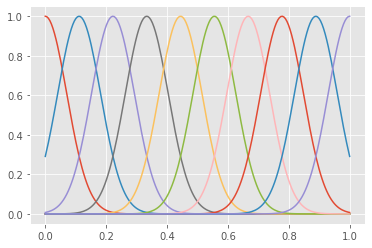

In [8]:
# Display the basis functions
from numpy.linalg import multi_dot as mat_mul
t = np.linspace(0,1,N2)
plt.plot(t,Phi)
# plt.plot(t,mat_mul([Phi, np.ones(Nb)]))

In [9]:
# Generate Trajectories: Sample from the distribution
p = 10
X_ = [None]*p
for i in range(p):
    X_[i] = t_tools.anormal_sampling_2D(M,Cov)
   # print(X_[i].shape)

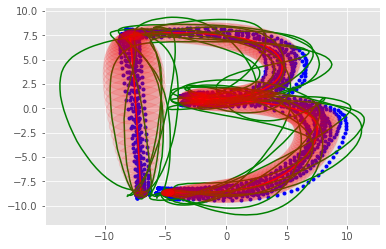

In [10]:
plt.figure
for i in range(0,len(demos)):
    plt.plot(tensor_data[i][0,:],tensor_data[i][1,:],'b.')
    
plt.plot(M[0,:],M[1,:], 'r')

for i in range(0,N2,1):
    pbd.plot_gmm([M[0,i],M[1,i]], Cov[1][i,i]*Cov[0],alpha=0.1)
    
for i in range(p):
    plt.plot(X_[i][0,:],X_[i][1,:], 'g')
# plt.title('Demonstrations')
# plt.axis('equal')

#plt.axis('tight')

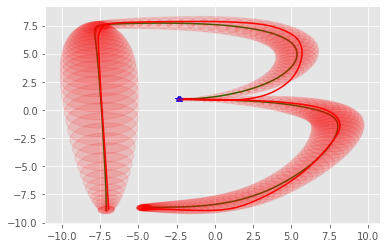

In [11]:
plt.figure
X = tensor_data[5]
k = 100

Ia = [k, k+2,k+3 ]
X_a = X[:,Ia].reshape(2,len(Ia)) #+ np.random.randn(2,len(Ia))
M_o, Cov_o, _, _ = t_tools.anormal_condition_2D(M,Cov,Ia,X_a)
M_oo = M[:,:]
Ib = list(set(range(M.shape[1]))- set(Ia))
M_oo[:,Ib] = M_o
M_oo[:,Ia] = X_a
plt.plot(M_oo[0,:],M_oo[1,:], 'g')
plt.plot(X[0,:],X[1,:], 'r')
plt.plot(X_a[0],X_a[1], 'b*')

for i in range(0,N2-5,1):
    pbd.plot_gmm([M_o[0,i],M_o[1,i]], Cov_o[1][i,i]*Cov_o[0],alpha=0.1)
    

### ProMP Analysis

#### Define basis functions

In [12]:

def rbf(x1,x2,h=1E-2):
    return np.exp(-(0.5/h)*np.dot(x1-x2,x1-x2))

In [13]:
a = np.identity(5)
b =a.flatten()
print(b)

[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1.]


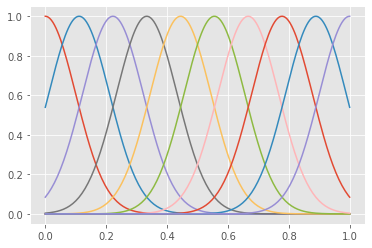

In [14]:


nb = 10
c = np.linspace(0,1,nb)     # centers of basis functions

q = np.zeros((t.shape[0],nb))
for i in range(0,t.shape[0]):
    for j in range(0,nb):
        q[i,j] = rbf(t[i],c[j])      

plt.figure
plt.plot(t,q)

### Compute weights

In [15]:
#lambd = 1E-10
lambd = 0
w = np.zeros((len(demos),2*nb))

n_w = 0
for demo in demos:
    
    x = demo[1:3,:]
    x = x.T.reshape(-1,1)
    phi = np.zeros(nb)
    Phi_tmp = np.zeros((2,2*nb,demo.shape[1]))
    for k in range(0,demo.shape[1]):
        for j in range(0, nb):
            phi[j] = rbf(demo[0,k],c[j])
        Phi_tmp[:,:,k] = np.kron(np.eye(2) ,phi)
    #Phi = np.zeros((2*demo.shape[1],2*nb))
    Phi = np.zeros((2*demo.shape[1],2*nb))
    for i in range(0,demo.shape[1]):
    #    Phi[2*i:2*i+2,(2*nb*i):2*nb*(i+1)]=Phi_tmp[:,:,i]
        Phi[2*i:2*i+2,:]=Phi_tmp[:,:,i]
    w[n_w,:] = np.dot(np.linalg.inv(np.dot(Phi.T,Phi)+lambd*np.eye(Phi.shape[1])),np.dot(Phi.T,x)).reshape(2*nb)
    n_w+=1

### Regression

In [16]:
# Compute weight distribution
u_w = np.mean(w,0)
cov_w = np.cov(w.T)

In [17]:
# Compute Phi for new inputs
t = np.linspace(0,1,1000)
n_test = t.shape[0]
Phi_tmp = np.zeros((2,2*nb,n_test))

for k in range(0,t.shape[0]):
    for j in range(0, nb):
        phi[j] = rbf(t[k],c[j])
    Phi_tmp[:,:,k] = np.kron(np.eye(2),phi)

Phi = np.zeros((2*n_test,2*nb))
for i in range(0,n_test):
    Phi[2*i:2*i+2,:]=Phi_tmp[:,:,i]
    
x_new_vec = np.dot(Phi,u_w)
x_new = np.array([np.dot(Phi,u_w)[0:-2:2],np.dot(Phi,u_w)[1:-1:2]]) # put the 2 rows in a list and make an ndarray

(-9.746535734560691,
 10.832151537529237,
 -11.344986045224559,
 9.168578212109319)

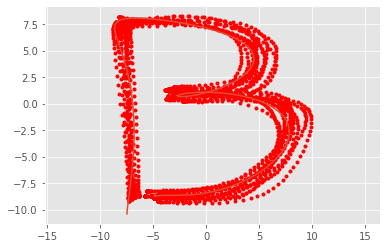

In [18]:
# Plot generated trajectory
plt.figure
for i in range(0,len(demos)):
    plt.plot(demos[i][1,:],demos[i][2,:],'r.')
plt.plot(x_new[0,:],x_new[1,:])
plt.axis('equal')

### Via-points

In [19]:
x_test = np.zeros((2,n_test,100))
for n in range(0,100):
    w_test = np.random.multivariate_normal(u_w,cov_w)
    x_test[:,:,n] = np.array([np.dot(Phi,w_test)[0::2],np.dot(Phi,w_test)[1::2]]) # put the 2 rows in 